# Eisamay property log analysis

> **The aim of this analysis is to identify and correct the various types of errors which reach our vm machines and aim to fix them. By analysing the logs and identifying where we are facing the errors we can:**
* improve our websites response rate 
* reduce bounce rate.
* Identify key sources of errors
* Identify key problems within our code base which would be applicable across properties
* Identify platform / property / VM  specific errors 


## Library imports and data understanding

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

In [34]:
# Reading the log file
df = pd.read_csv('lang-error-17-12-2020.csv',index_col=False)

In [239]:
# Seeing data
df.head(5)

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC,PARSED_TIME,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR,PARSED_DATE_TIME
0,172.29.63.76,17-12-2020 0:0:5,desktop,https://eisamay.indiatimes.com/entertainment/cinema/articlelist/51012377.cms,https://eisamay.indiatimes.com/pwafeeds/sc_gadgetlist.cms?category=mobile&feedtype=sjson&pagetype=widget&perpage=10&sort=latest,Error: Request failed with status code 404,00:00:05,articlelist,404,False,2020-12-17 00:00:05
1,172.29.63.76,17-12-2020 0:0:7,desktop,https://eisamay.indiatimes.com/entertainment/cinema/articlelist/51012377.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat ServerResponse.setHeader (_http_outgoing.js:481:11)at y (/opt/deployment/production/eisweb_63/dist/server.js:1:1085991)at Object.<anonymous> (/opt/deployment/production/eisweb_63/dist/server.js:1:1090471)at tryCatch (/opt/deployment/production/eisweb_63/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/eisweb_63/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/eisweb_63/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/eisweb_63/dist/server.js:1:1080407)at /opt/deployment/production/eisweb_63/dist/server.js:1:1080553at new Promise (/opt/deployment/production/eisweb_63/node_modules/core-js/modules/es6.promise.js:177:7)at /opt/deployment/production/eisweb_63/dist/server.js:1:1080351',00:00:07,articlelist,ERR_HTTP_HEADERS_SENT,False,2020-12-17 00:00:07
2,172.29.63.76,17-12-2020 0:0:8,mobile,https://eisamay.indiatimes.com/west-bengal-news/24pargana-news/articlelist/49780592.cms,https://eisamay.indiatimes.com/pwafeeds/sc_gadgetlist.cms?category=mobile&feedtype=sjson&pagetype=widget&perpage=10&sort=latest,Error: Request failed with status code 404,00:00:08,articlelist,404,False,2020-12-17 00:00:08
3,172.29.63.76,17-12-2020 0:0:14,mobile,https://eisamay.indiatimes.com/bangla-news-live/-/amp_articleshow/63640426.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/eismweb_79/dist/server.js:1:182185)at /opt/deployment/production/eismweb_79/dist/server.js:1:440852at O (/opt/deployment/production/eismweb_79/dist/server.js:1:441056)at e.t.render (/opt/deployment/production/eismweb_79/dist/server.js:1:450327)at e.t.read (/opt/deployment/production/eismweb_79/dist/server.js:1:449906)at renderToString (/opt/deployment/production/eismweb_79/dist/server.js:1:455097)at w (/opt/deployment/production/eismweb_79/dist/server.js:1:1243482)at Object.<anonymous> (/opt/deployment/production/eismweb_79/dist/server.js:1:1247299)at tryCatch (/opt/deployment/production/eismweb_79/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/eismweb_79/node_modules/regenerator-runtime/runtime.js:303:22)',00:00:14,articleshow,undefined,True,2020-12-17 00:00:14
4,172.29.63.76,17-12-2020 0:0:16,desktop,https://eisamay.indiatimes.com/videos/entertainment/vidyas-kahaani-2-to-clash-with-srk-alias-dear-zindagi-now/videoshow/54488137.cms/feeds/vod_player.cms?autoplay=0&dim=0&msid=54488137&source=article&userInitiated=1&videosection=article-show,NaN,'TypeError: Cannot read property 'components' of undefinedat c (/opt/deployment/production/eisweb_63/dist/server.js:1:1081152)at /opt/deployment/production/eisweb_63/dist/server.js:1:1089765at /opt/deployment/production/eisweb_63/node_modules/react-router/lib/match.js:67:5at /opt/deployment/production/eisweb_63/node_modules/react-router/lib/createTransitionManager.js:72:11at next (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/AsyncUtils.js:52:7)at loopAsync (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/AsyncUtils.js:56:3)at matchRoutes (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/matchRoutes.js:245:29)at Object.match (/opt/deployment/productio

> **Dropping any duplicate types of errors based on the following combination**

In [36]:

df.drop_duplicates(subset=['PLATFORM','REQ_URL', 'REQ_FEED','DESC'], keep='last')
df.shape

(14154, 6)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14154 entries, 0 to 14153
Data columns (total 6 columns):
IP          14154 non-null object
TIME        14154 non-null object
PLATFORM    14154 non-null object
REQ_URL     14154 non-null object
REQ_FEED    5921 non-null object
DESC        14154 non-null object
dtypes: object(6)
memory usage: 663.5+ KB


* **Parsing time to get a more accurate analysis if needed**

In [71]:
# Adding parsed time 
df['PARSED_DATE_TIME'] = pd.to_datetime(df['TIME'], format='%d-%m-%Y %H:%M:%S')
df['PARSED_DATE_TIME'].dt.time.head()
df['PARSED_TIME'] = df['PARSED_DATE_TIME'].dt.time
df['PARSED_TIME'].head()

0    00:00:05
1    00:00:07
2    00:00:08
3    00:00:14
4    00:00:16
Name: PARSED_TIME, dtype: object

* **Categorizing urls based on page types**

In [41]:
def categorize_url(url):
    templates = ['articleshow','photoshow','photolist','videoshow','articlelist','topics']
    for template in templates:
        if template in url:
            return template
    return 'others'
df['URL_CATEGORY'] = df['REQ_URL'].apply(categorize_url)


* **Categorizing the various types of errors found**

In [43]:
# How i found the categories:
# First inspected the df, found 404 and undefined, started with these as a base along with null
# Characterized others as "others" manually inspected others one by one and
# found: 410 ,403, ['object Object'] timeout
def categorize_error(error):
    #     categories = ['null','undefined','404','410','ERR_HTTP_HEADERS_SENT','9000ms']
    categories = {
       '[object Object]':'[object Object]','undefined':'undefined','404':'404','410':'410','ECONNRESET':'ECONNRESET','ERR_HTTP_HEADERS_SENT':'ERR_HTTP_HEADERS_SENT','9000ms':'timeout'       
    }
    for cat in categories:
        if cat in error:
            return categories[cat]
    return 'other'
            
df['ERROR_TYPE'] = df['DESC'].apply(categorize_error)

In [45]:
# Very vague type of error
df['DESC'][df['ERROR_TYPE'] == '[object Object]']

107      '[object Object]'
112      '[object Object]'
119      '[object Object]'
125      '[object Object]'
181      '[object Object]'
336      '[object Object]'
663      '[object Object]'
700      '[object Object]'
932      '[object Object]'
933      '[object Object]'
946      '[object Object]'
979      '[object Object]'
1329     '[object Object]'
1332     '[object Object]'
1381     '[object Object]'
1385     '[object Object]'
1829     '[object Object]'
1901     '[object Object]'
2035     '[object Object]'
2039     '[object Object]'
2049     '[object Object]'
2050     '[object Object]'
2052     '[object Object]'
2053     '[object Object]'
2111     '[object Object]'
2171     '[object Object]'
2228     '[object Object]'
2422     '[object Object]'
2423     '[object Object]'
2425     '[object Object]'
               ...        
10467    '[object Object]'
10683    '[object Object]'
10685    '[object Object]'
10693    '[object Object]'
10720    '[object Object]'
10743    '[object Object]'
1

In [ ]:
* **Categorizing platform level errors ie, mobile or desktop**

In [39]:
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
df['PLATFORM'].value_counts(normalize=True)

desktop    0.712873
mobile     0.287127
Name: PLATFORM, dtype: float64

In [40]:
## Seeing feed errors vs others
df[~(df['REQ_FEED'].isnull())].count()[0] / df.shape[0] 
# 41.8 percent feederrors 

0.41832697470679664

In [46]:
# Further inspection reveals that some urls are broken with '-' in between. It will be useful if we categorize these.
df['REQ_URL'][df['ERROR_TYPE'] == '[object Object]']

107      https://eisamay.indiatimes.com/nation/army-officer-shot-dead-by-jawan-in-uri-sector-in-jammu-and-kashmir/-/jawan/photoshow/59645394.cms                                                                                                                                                  
112      https://eisamay.indiatimes.com/business/business-news/jana-small-finance-bank-provides-9-6-interest-rate-on-fixed-deposit/photoshow/68437855.cms                                                                                                                                         
119      https://eisamay.indiatimes.com/lifestyle/health-fitness/6-proven-health-benefits-of-dates/photoshow/68343345.cms                                                                                                                                                                         
125      https://eisamay.indiatimes.com/business/business-news/jana-small-finance-bank-provides-9-6-interest-rate-on-fixed-depo

In [47]:
# Categories to check where we failed in urls
# Manually inspecting, i found '-/' '/-/' and cases like
df['IS_URL_ERROR'] = df['REQ_URL'].apply(lambda x: '/-/' in x or '-/' in x)

In [48]:
df['IS_URL_ERROR'].value_counts()

False    12643
True     1511 
Name: IS_URL_ERROR, dtype: int64

In [44]:
df['ERROR_TYPE'].value_counts()

ERR_HTTP_HEADERS_SENT    6417
404                      5738
undefined                1713
410                      129 
[object Object]          100 
other                    27  
timeout                  25  
ECONNRESET               5   
Name: ERROR_TYPE, dtype: int64

In [42]:
df['URL_CATEGORY'].value_counts()

articlelist    6028
articleshow    5244
videoshow      1511
photoshow      737 
others         499 
photolist      110 
topics         25  
Name: URL_CATEGORY, dtype: int64

## Visualizing the errors

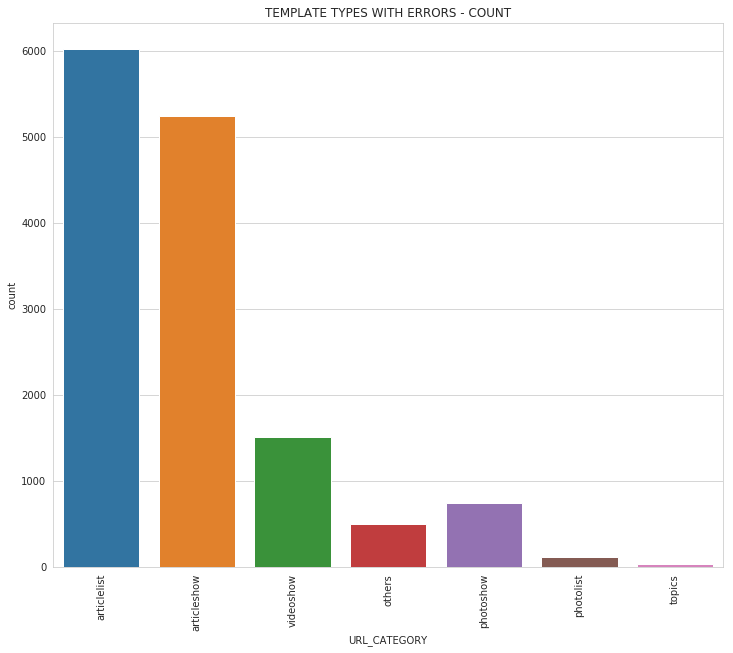

In [154]:
## Template error count
plt.figure(figsize=(12,10))
plt.title("TEMPLATE TYPES WITH ERRORS - COUNT")
plt.xlabel("TEMPLATE - TYPES")
plt.ylabel("COUNT")
plt.xticks(rotation=90)
sns.countplot(df['URL_CATEGORY'])
plt.show()

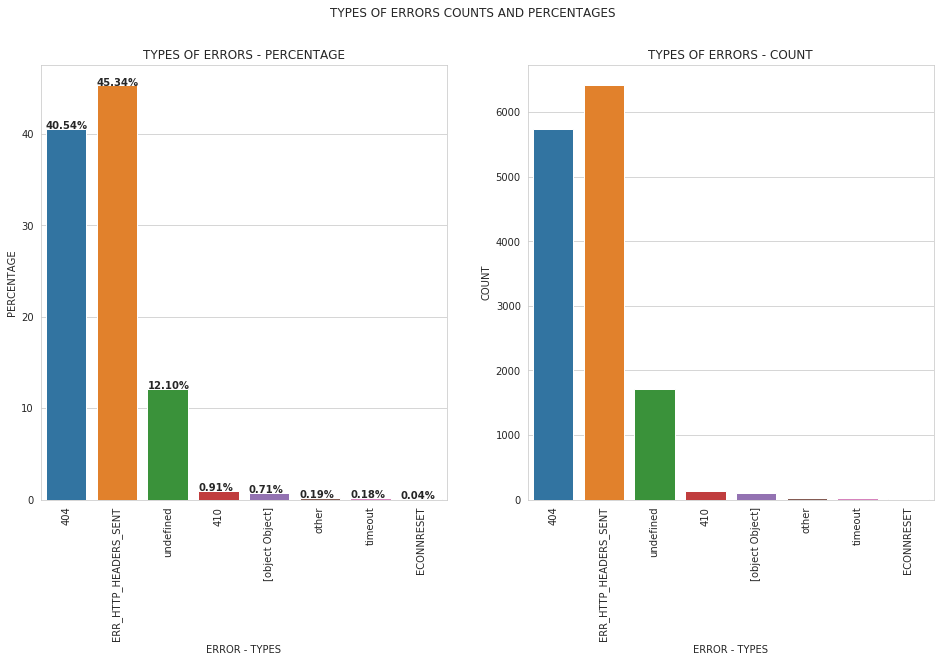

In [225]:

fig,ax= plt.subplots(1,2,figsize=(16,8))
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)

bp = sns.barplot(data=df,x='ERROR_TYPE',y='ERROR_TYPE',orient='v',estimator=lambda x: len(x) / len(df) * 100,ax=ax[0])
for rect in bp.patches:
    bp.text (rect.get_x() + rect.get_width() // 2,rect.get_height(),"%.2f%%"% rect.get_height(), weight='bold' )
ax[0].set_title("TYPES OF ERRORS - PERCENTAGE")
ax[0].set_xlabel("ERROR - TYPES")
ax[0].set_ylabel("PERCENTAGE")

## Error types counts
sns.countplot(df['ERROR_TYPE'],ax=ax[1])
ax[1].set_title('TYPES OF ERRORS - COUNT')
ax[1].set_xlabel("ERROR - TYPES")
ax[1].set_ylabel("COUNT")

fig.suptitle('TYPES OF ERRORS COUNTS AND PERCENTAGES')

plt.show()


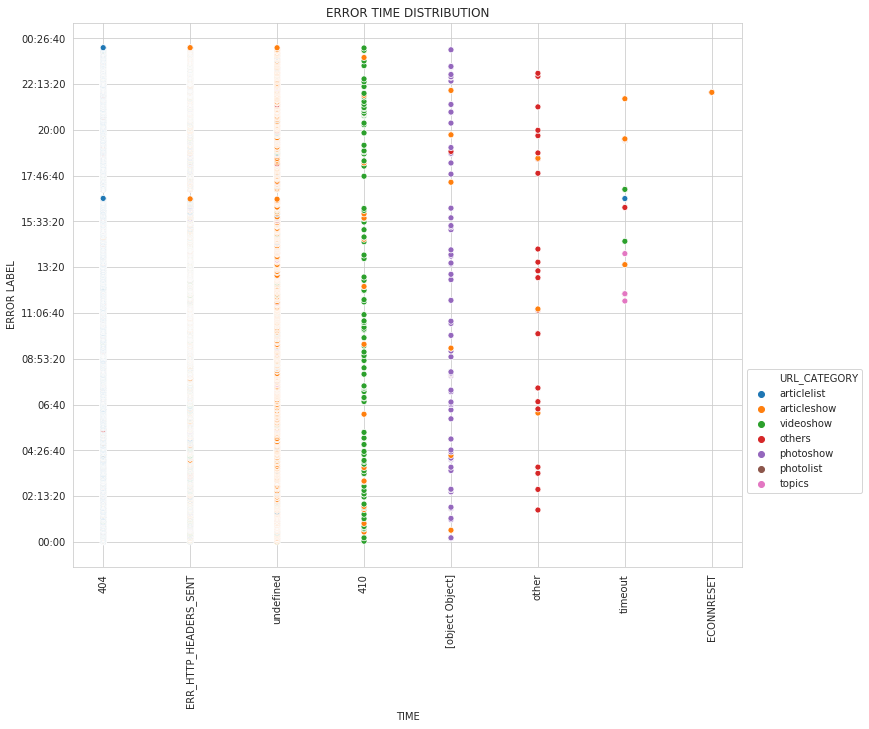

In [108]:
plt.figure(figsize=(12,10))
import matplotlib.ticker as ticker
ax = plt.axes()
sns.set_style("whitegrid")
g = sns.scatterplot(data =df,y='PARSED_TIME',x='ERROR_TYPE',hue="URL_CATEGORY")
plt.title("ERROR TIME DISTRIBUTION")
plt.xlabel("TIME")
plt.ylabel("ERROR LABEL")

ax.yaxis.set_major_locator(ticker.MultipleLocator(8000))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.25), ncol=1)
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=90)
plt.show()

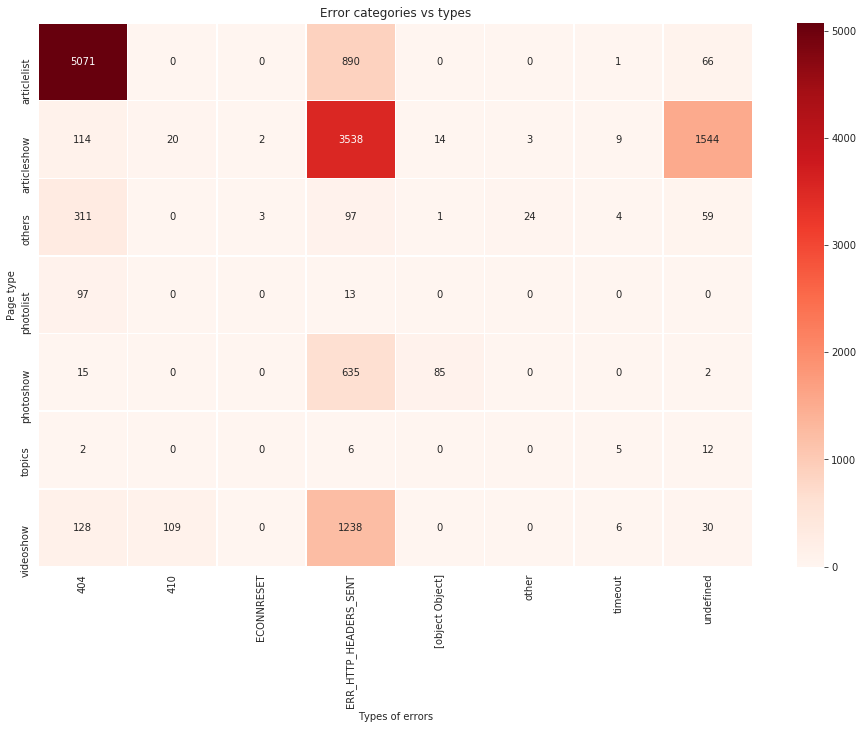

In [237]:
# Creating what type of templates have what type of errors
plt.figure(figsize=(16,10))
categories_vs_error =  df.groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
sns.heatmap(categories_vs_error,linewidths=.5,annot=True,cmap='Reds',fmt="d")
plt.title('Error categories vs types')
plt.xlabel('Types of errors')
plt.ylabel('Page type')
plt.show()